In [23]:
# Import necessary libraries
import sys
sys.path.insert(0, '..')  # add the parent directory to path
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import librosa
import librosa.display
from sklearn.svm import OneClassSVM
from sklearn import metrics
import plotly.express as px
from get_mel_spectrogram import get_mel_spectrogram

In [2]:
# Directories
parent_dir = os.path.abspath('..')  # parent directory
# Audio data directory
data_dir = os.path.join(parent_dir, 'data', 'source')  # audio data directory
# Metada directory
metadata_dir = os.path.join(parent_dir, 'data', 'metadata')  # metadata directory

In [3]:
# Read the metadata file
df = pd.read_csv(os.path.join(metadata_dir, 'metadata.csv'), header=0, index_col=0)
df

,machine,model,anomaly,file_name,file_rel_path,duration_s,fs_Hz,SNR_dB
file_no,,,,,,,,
0,fan,0,1,00000000.wav,6_dB_fan\fan\id_00\abnormal\00000000.wav,10.0,16000,6
1,fan,0,1,00000001.wav,6_dB_fan\fan\id_00\abnormal\00000001.wav,10.0,16000,6
2,fan,0,1,00000002.wav,6_dB_fan\fan\id_00\abnormal\00000002.wav,10.0,16000,6
3,fan,0,1,00000003.wav,6_dB_fan\fan\id_00\abnormal\00000003.wav,10.0,16000,6
4,fan,0,1,00000004.wav,6_dB_fan\fan\id_00\abnormal\00000004.wav,10.0,16000,6
...,...,...,...,...,...,...,...,...
18014,valve,6,0,00000987.wav,6_dB_valve\valve\id_06\normal\00000987.wav,10.0,16000,6
18015,valve,6,0,00000988.wav,6_dB_valve\valve\id_06\normal\00000988.wav,10.0,16000,6
18016,valve,6,0,00000989.wav,6_dB_valve\valve\id_06\normal\00000989.wav,10.0,16000,6


In [4]:
# Randomly select a subset of samples for a single machine
machine = 'fan'
df_machine = df[df.machine=='fan']

df_machine = df_machine.groupby(["model", "anomaly"]).sample(frac=0.6, random_state=13)
df_machine.groupby(["model", "anomaly"])['file_name'].count().reset_index(name='count')

,model,anomaly,count
0,0,0,607
1,0,1,244
2,2,0,610
3,2,1,215
4,4,0,620
5,4,1,209
6,6,0,609
7,6,1,217


In [5]:
df_machine

,machine,model,anomaly,file_name,file_rel_path,duration_s,fs_Hz,SNR_dB
file_no,,,,,,,,
1112,fan,0,0,00000705.wav,6_dB_fan\fan\id_00\normal\00000705.wav,10.0,16000,6
407,fan,0,0,00000000.wav,6_dB_fan\fan\id_00\normal\00000000.wav,10.0,16000,6
477,fan,0,0,00000070.wav,6_dB_fan\fan\id_00\normal\00000070.wav,10.0,16000,6
1266,fan,0,0,00000859.wav,6_dB_fan\fan\id_00\normal\00000859.wav,10.0,16000,6
1059,fan,0,0,00000652.wav,6_dB_fan\fan\id_00\normal\00000652.wav,10.0,16000,6
...,...,...,...,...,...,...,...,...
4403,fan,6,1,00000229.wav,6_dB_fan\fan\id_06\abnormal\00000229.wav,10.0,16000,6
4415,fan,6,1,00000241.wav,6_dB_fan\fan\id_06\abnormal\00000241.wav,10.0,16000,6
4175,fan,6,1,00000001.wav,6_dB_fan\fan\id_06\abnormal\00000001.wav,10.0,16000,6


{'window': 0.5, 'window_length': 8000, 'overlap': 0.25, 'overlap_length': 2000, 'hop_length': 6000, 'n_fft': 8192, 'n_mels': 64, 'fmin': 0, 'fmax': 8000.0, 'mel_center_freq': array([  46.875   ,   93.75    ,  138.671875,  185.546875,  232.421875,
        279.296875,  324.21875 ,  371.09375 ,  417.96875 ,  464.84375 ,
        509.765625,  556.640625,  603.515625,  650.390625,  695.3125  ,
        742.1875  ,  789.0625  ,  835.9375  ,  880.859375,  927.734375,
        974.609375, 1021.484375, 1072.265625, 1125.      , 1179.6875  ,
       1238.28125 , 1298.828125, 1361.328125, 1427.734375, 1498.046875,
       1572.265625, 1648.4375  , 1730.46875 , 1814.453125, 1904.296875,
       1996.09375 , 2095.703125, 2197.265625, 2304.6875  , 2417.96875 ,
       2537.109375, 2660.15625 , 2791.015625, 2927.734375, 3072.265625,
       3222.65625 , 3380.859375, 3546.875   , 3720.703125, 3902.34375 ,
       4093.75    , 4294.921875, 4503.90625 , 4726.5625  , 4957.03125 ,
       5201.171875, 5455.078125, 

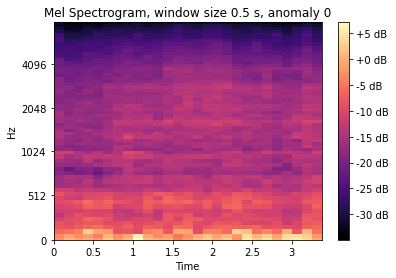

In [6]:
# Compute and plot mel spectrogram
no_file = 600
file_path = os.path.join(data_dir, df_machine.iloc[no_file].file_rel_path)
fs = df_machine.iloc[no_file].fs_Hz
window = 0.5 # 2
n_mels = 64
mel_spect, mel_spect_db, mfcc, params = get_mel_spectrogram(file_path, window=window, overlap=0.25, n_mels=n_mels, machine='pump') 

print(params)

print(f"Size of mel_spect: {mel_spect.shape}, total number of points: {mel_spect.size}")
librosa.display.specshow(mel_spect_db, sr=fs, hop_length=params['overlap_length'], x_axis='time', y_axis='mel');

plt.title(f"Mel Spectrogram, window size {params['window']} s, anomaly {df_machine.iloc[no_file].anomaly}");
plt.colorbar(format='%+2.0f dB');

array([  46.875   ,   93.75    ,  138.671875,  185.546875,  232.421875,
        279.296875,  324.21875 ,  371.09375 ,  417.96875 ,  464.84375 ,
        509.765625,  556.640625,  603.515625,  650.390625,  695.3125  ,
        742.1875  ,  789.0625  ,  835.9375  ,  880.859375,  927.734375,
        974.609375, 1021.484375, 1072.265625, 1125.      , 1179.6875  ,
       1238.28125 , 1298.828125, 1361.328125, 1427.734375, 1498.046875,
       1572.265625, 1648.4375  , 1730.46875 , 1814.453125, 1904.296875,
       1996.09375 , 2095.703125, 2197.265625, 2304.6875  , 2417.96875 ,
       2537.109375, 2660.15625 , 2791.015625, 2927.734375, 3072.265625,
       3222.65625 , 3380.859375, 3546.875   , 3720.703125, 3902.34375 ,
       4093.75    , 4294.921875, 4503.90625 , 4726.5625  , 4957.03125 ,
       5201.171875, 5455.078125, 5722.65625 , 6003.90625 , 6296.875   ,
       6605.46875 , 6929.6875  , 7269.53125 , 7626.953125])

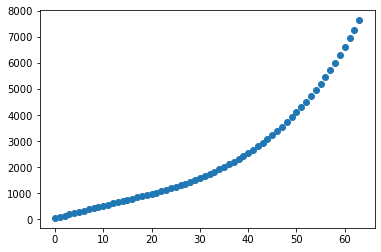

In [7]:
plt.scatter(range(len(params['mel_center_freq'])), params['mel_center_freq'])
params['mel_center_freq']

In [48]:
def get_melspec_features_from_files(df_input, window, n_mels, overlap=0.5):
    
    X = []
    y = []

    for idx, row in df_input.iterrows():
        file_path = os.path.join(data_dir, row.file_rel_path)
        fs = row.fs_Hz

        mel_spect, mel_spect_db, mfcc, params = get_mel_spectrogram(file_path, 
                                                                    window=window, 
                                                                    overlap=overlap,
                                                                    n_mels=n_mels, 
                                                                    machine=row.machine)
        
        sample_features = mel_spect_db.flatten().reshape(-1, 1)    
        sample_target = row.anomaly
        X.append(sample_features)
        y.append(sample_target)
        
    X = np.array(X)
    X = X[:,:,0]
    y = np.array(y).reshape(-1, 1)
        
    return X, y, params

In [49]:
window = 0.5
n_mels = 64
overlap = 0.25

X, y, params = get_melspec_features_from_files(df_machine, window, n_mels, overlap)
print(X.shape)
print(y.shape)

(3331, 1728)
(3331, 1)


In [51]:
# Separate data into training and test sets
# All abnormal samples are in the test set
# Equal number of normal samples in the test set
# Remaining in the training set
no_abnormal_test = sum(df_machine.anomaly==1)
no_normal_test = no_abnormal_test
no_normal_training = df_machine.shape[0]-no_normal_test-no_abnormal_test

df_machine['test_train'] = 0
df_machine.loc[df_machine.anomaly==1, 'test_train'] = 1
random.seed(12)
ind_normal_test = random.sample(list(df_machine[df_machine.anomaly==0].index), no_normal_test)
df_machine.loc[ind_normal_test, 'test_train'] = 1

df_machine.groupby(['anomaly','test_train']).count()

machine  model  file_name  file_rel_path  duration_s  \
anomaly test_train                                                         
0       0              1561   1561       1561           1561        1561   
        1               885    885        885            885         885   
1       1               885    885        885            885         885   

                    fs_Hz  SNR_dB  
anomaly test_train                 
0       0            1561    1561  
        1             885     885  
1       1             885     885

In [52]:
X_train = X[(df_machine.test_train==0).squeeze(), :]  
X_test = X[(df_machine.test_train==1).squeeze(), :]
y_train = y[(df_machine.test_train==0).squeeze(), :]  
y_test = y[(df_machine.test_train==1).squeeze(), :]

In [54]:
# Standardizing each feature using the train mean and standard deviation
for no_feat in range(X_train.shape[1]):
    minval = np.min(X_train[:,no_feat])
    maxval = np.max(X_train[:,no_feat])
    
    X_train[:,no_feat] = (X_train[:,no_feat]-minval)/(maxval-minval)
    X_test[:,no_feat] = (X_test[:,no_feat]-minval)/(maxval-minval)

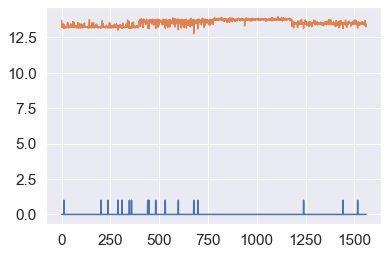

In [55]:
plt.plot(y_train_pred)
plt.plot(scores_training)
plt.show()

In [112]:
print(1/X_train.shape[0])
1/X_train.shape[0]/X_train.var()

0.0006406149903907751


0.011893273909719566

(array([  8.,  30.,  93., 137., 250., 375., 293., 225., 129.,  21.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

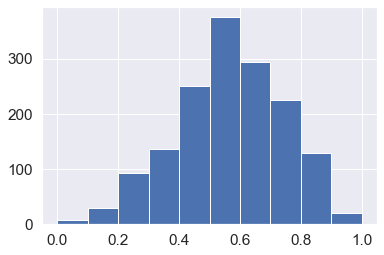

In [107]:
# Histogram of features
plt.hist(X_train[:,10])

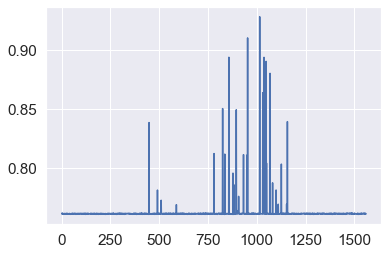

In [214]:
plt.plot(scores_training)

              precision    recall  f1-score   support

           0       0.72      0.97      0.83       885
           1       0.96      0.62      0.76       885

    accuracy                           0.80      1770
   macro avg       0.84      0.80      0.79      1770
weighted avg       0.84      0.80      0.79      1770

[[862  23]
 [334 551]]


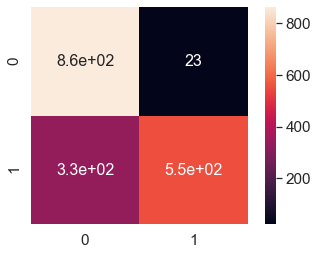

In [149]:
# Classifying with classifier output
# We should decide the values of gamma, nu and prctle
gamma = 0.01
nu = 0.01
svm = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)  # create classifier

svm.fit(X_train)  # fit training data
y_train_pred = svm.predict(X_train)  # predict training targets
y_train_pred = np.array([1 if elem==-1 else 0 for elem in y_train_pred]).reshape(-1, 1)
scores_training = svm.score_samples(X_train)  # scores for training data

# Threshold from scores of training set
prctle = 2
thresh = np.percentile(scores_training, prctle)

y_test_pred_score = np.array([1 if elem<thresh else 0 for elem in scores_test]).reshape(-1, 1)

# Test set
y_test_pred = svm.predict(X_test)
y_test_pred = np.array([1 if elem==-1 else 0 for elem in y_test_pred]).reshape(-1, 1)
scores_test = svm.score_samples(X_test)
y_test_pred_score = np.array([1 if elem<thresh else 0 for elem in scores_test]).reshape(-1, 1)

# plt.scatter(X_train[(y_train_pred==0).squeeze(),0], X_train[(y_train_pred==0).squeeze(),100], color='b')
# plt.scatter(X_train[(y_train_pred==1).squeeze(),0], X_train[(y_train_pred==1).squeeze(),300], color='g')
# plt.scatter(X_test[(y_test_pred==0).squeeze(),0], X_test[(y_test_pred==0).squeeze(),300], color='k')
# plt.scatter(X_test[(y_test_pred==1).squeeze(),0], X_test[(y_test_pred==1).squeeze(),300], color='r')
# plt.show()

report = metrics.classification_report(y_test, y_test_pred_score)
print(report)

cm = metrics.confusion_matrix(y_test, y_test_pred_score)
print(cm)
plt.imshow(cm)

df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [166]:
ran_gamma = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
ran_prctl = range(0,10)
nu = 0.5
acc_gn = np.zeros((len(ran_prctl), len(ran_gamma)))
precision_gn = np.zeros((len(ran_prctl), len(ran_gamma)))
recall_gn = np.zeros((len(ran_prctl), len(ran_gamma)))
TPR_gn = np.zeros((len(ran_prctl), len(ran_gamma)))
FPR_gn = np.zeros((len(ran_prctl), len(ran_gamma)))
for id_g, gamma in enumerate(ran_gamma):
    for id_p, prctle in enumerate(ran_prctl):
        #prctle = 2
        svm = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)  # create classifier

        svm.fit(X_train)  # fit training data
        y_train_pred = svm.predict(X_train)  # predict training targets
        y_train_pred = np.array([1 if elem==-1 else 0 for elem in y_train_pred]).reshape(-1, 1)
        scores_training = svm.score_samples(X_train)  # scores for training data

        # Threshold from scores of training set
        thresh = np.percentile(scores_training, prctle)

        y_test_pred_score = np.array([1 if elem<thresh else 0 for elem in scores_test]).reshape(-1, 1)

        # Test set
        y_test_pred = svm.predict(X_test)
        y_test_pred = np.array([1 if elem==-1 else 0 for elem in y_test_pred]).reshape(-1, 1)
        scores_test = svm.score_samples(X_test)
        y_test_pred_score = np.array([1 if elem<thresh else 0 for elem in scores_test]).reshape(-1, 1)

        report = metrics.classification_report(y_test, y_test_pred_score)

        cm = metrics.confusion_matrix(y_test, y_test_pred_score)

        out_metrics = confusion_metrics(cm)
        acc_gn[id_p, id_g] = out_metrics['acc']
        precision_gn[id_p, id_g] = out_metrics['precision']
        recall_gn[id_p, id_g] = out_metrics['recall']
        TPR_gn[id_p, id_g] = out_metrics['TPR']
        FPR_gn[id_p, id_g] = out_metrics['FPR']

In [176]:
ran_prctl

range(0, 10)

0.0001
0.0005
0.001
0.005
0.01
0.05
0.1
0.5


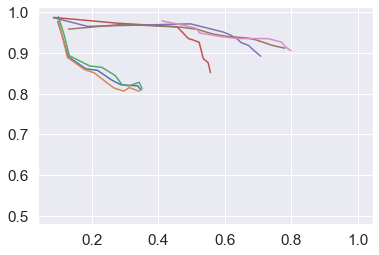

In [222]:
for id_g, gamma in enumerate(ran_gamma):
    if(id_g<10):
        print(gamma)
        plt.plot(recall_gn[:, id_g], precision_gn[:, id_g])

plt.show()

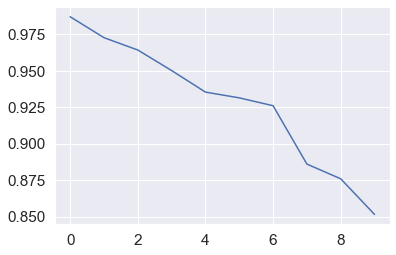

In [213]:
id_g_selected = 3
ran_gamma[id_g_selected]
plt.plot(precision_gn[:, id_g_selected])
plt.show()

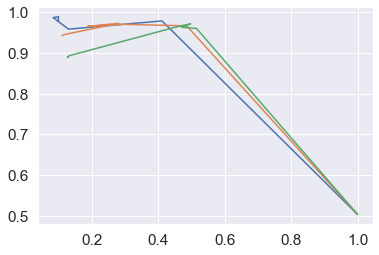

In [207]:
for id_p, prctl in enumerate(ran_prctl):
    if(id_p<3):
        plt.plot(recall_gn[id_p, :], precision_gn[id_p, :])

plt.show()

0.005


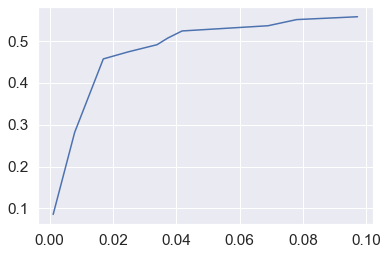

In [219]:
for id_g, gamma in enumerate(ran_gamma):
    if(id_g==3):
        print(gamma)
        plt.plot(FPR_gn[:, id_g], TPR_gn[:, id_g])

plt.show()

In [147]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
    
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    
    # Accuracy
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # Precision and recall
    precision = TP / float(TP + FP)
    recall = TP / float(TP + FN)
    
    # Sensitivity and specificity
    sensitivity = recall
    specificity = (TN / float(TN + FP))
    
    # TPR and FPR
    TPR = recall
    FPR = 1-specificity
    
    # F_1 score
    f1 = 2 * ((precision * sensitivity) / (precision + sensitivity))
    
    out_metrics = {'acc': accuracy,
                  'precision': precision,
                  'recall': recall,
                  'sensitivity': sensitivity,
                  'specificity': specificity,
                  'TPR': TPR,
                  'FPR': FPR,
                  'f1': f1}
    
    return out_metrics

In [ ]:
# Randomly select a subset of samples for a single machine
machine = 'fan'
df_machine_all = df[df.machine=='fan']
  
window = 0.5
n_mels = 64
overlap = 0.25

X_all, y_all, params_all = get_melspec_features_from_files(df_machine_all, window, n_mels, overlap)
print(X_all.shape)
print(y_all.shape)

# Separate data into training and test sets
# All abnormal samples are in the test set
# Equal number of normal samples in the test set
# Remaining in the training set
no_abnormal_test = sum(df_machine_all.anomaly==1)
no_normal_test = no_abnormal_test
no_normal_training = df_machine_all.shape[0]-no_normal_test-no_abnormal_test

df_machine_all['test_train'] = 0
df_machine_all.loc[df_machine_all.anomaly==1, 'test_train'] = 1
random.seed(12)
ind_normal_test = random.sample(list(df_machine_all[df_machine_all.anomaly==0].index), no_normal_test)
df_machine_all.loc[ind_normal_test, 'test_train'] = 1

df_machine_all.groupby(['anomaly','test_train']).count()


X_train_all = X_all[(df_machine_all.test_train==0).squeeze(), :]  
X_test_all = X_all[(df_machine_all.test_train==1).squeeze(), :]
y_train_all = y_all[(df_machine_all.test_train==0).squeeze(), :]  
y_test_all_all = y_all[(df_machine_all.test_train==1).squeeze(), :]


# Standardizing each feature using the train mean and standard deviation
for no_feat in range(X_train_all.shape[1]):
    minval = np.min(X_train_all[:,no_feat])
    maxval = np.max(X_train_all[:,no_feat])
    
    X_train_all[:,no_feat] = (X_train_all[:,no_feat]-minval)/(maxval-minval)
    X_test_all[:,no_feat] = (X_test_all[:,no_feat]-minval)/(maxval-minval)
    

ran_gamma = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
prctl = 2
nu = 0.5
acc_gn = np.zeros((len(ran_prctl), len(ran_gamma)))
precision_gn = np.zeros((len(ran_prctl), len(ran_gamma)))
recall_gn = np.zeros((len(ran_prctl), len(ran_gamma)))
TPR_gn = np.zeros((len(ran_prctl), len(ran_gamma)))
FPR_gn = np.zeros((len(ran_prctl), len(ran_gamma)))
for id_g, gamma in enumerate(ran_gamma):
    svm = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)  # create classifier

    svm.fit(X_train_all)  # fit training data
    y_train_pred = svm.predict(X_train_all)  # predict training targets
    y_train_pred = np.array([1 if elem==-1 else 0 for elem in y_train_pred]).reshape(-1, 1)
    scores_training = svm.score_samples(X_train_all)  # scores for training data

    # Threshold from scores of training set
    thresh = np.percentile(scores_training, prctle)

    y_test_pred_score = np.array([1 if elem<thresh else 0 for elem in scores_test]).reshape(-1, 1)

    # Test set
    y_test_pred = svm.predict(X_test_all)
    y_test_pred = np.array([1 if elem==-1 else 0 for elem in y_test_pred]).reshape(-1, 1)
    scores_test = svm.score_samples(X_test_all)
    y_test_pred_score = np.array([1 if elem<thresh else 0 for elem in scores_test]).reshape(-1, 1)

    report = metrics.classification_report(y_test, y_test_pred_score)

    cm = metrics.confusion_matrix(y_test, y_test_pred_score)

    out_metrics_all = confusion_metrics(cm)
    acc_gamma_all[id_g] = out_metrics['acc']
    precision_gamma_all[id_g] = out_metrics['precision']
    recall_gamma_all[id_g] = out_metrics['recall']
    TPR_gamma_all[id_g] = out_metrics['TPR']
    FPR_gamma_all[id_g] = out_metrics['FPR']
    
    
    cm = metrics.confusion_matrix(y_train, y_train)

    out_metrics_all = confusion_metrics(cm)
    acc_gamma_all[id_g] = out_metrics['acc']
    precision_gamma_all[id_g] = out_metrics['precision']
    recall_gamma_all[id_g] = out_metrics['recall']
    TPR_gamma_all[id_g] = out_metrics['TPR']
    FPR_gamma_all[id_g] = out_metrics['FPR']